In [5]:
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from model import *
from trainer import *

## Initialize data

In [6]:
corpus = data.Corpus('./data/ptb')
ntokens = len(corpus.dictionary)

## Overhead stuff

Helper functions for batching, resetting hidden states, etc.

In [7]:
# Training hyperparameters
eval_batch_size = 10
batch_size = 74
seq_len = 18
dropout = 0.1
clip = 4
lr = 0.02
warmup_steps = 10
decay_factor = 0.5
smoothing = 0.05

epochs = 100
log_interval = 150  # Print log every `log_interval` batches

In [8]:
# Model hyperparameters
embed_size = 512
h_size = 256
decode_size = 256
n_enc_layers = 0
attn_rnn_layers = 1
n_dec_layers = 0
smooth_align = True
align_location = False
skip_connections = False

The learning rate scheduler sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

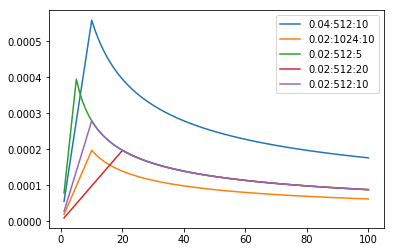

In [9]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps*2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.4g:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps*2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps),
])

## Initialize model, criterion, optimizer, and learning rate scheduler

In [10]:
model = RNNModel(
    src_vocab = ntokens, tgt_vocab = ntokens, embed_size = embed_size,
    h_size = h_size, decode_size = decode_size, n_enc_layers = n_enc_layers,
    attn_rnn_layers = attn_rnn_layers, n_dec_layers = n_dec_layers,
    align_location = align_location, skip_connections = skip_connections,
    smooth_align = smooth_align, dropout = dropout
)
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
eval_criterion = LabelSmoothing(ntokens, smoothing = 0)
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, decay_factor, optimizer)
# Reference
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 9003793


## Train
Ready the data

In [11]:
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)
train_data.size(), val_data.size(), test_data.size()

(torch.Size([12562, 74]), torch.Size([7376, 10]), torch.Size([8243, 10]))

Train and evaluate

In [ ]:
WIDTH = 112
CAUSES = ['output', 'grad']
for epoch in range(epochs):
    lr_scheduler.step()
    print('Epoch {:3d}/{:3d}) lr = {:0.4g}{}'.format(epoch+1, epochs, np.mean(lr_scheduler.get_lr()[0]), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    stat, train_loss, data, targets, states, nstates = train(
        model, train_data, batch_size, seq_len, ntokens,
        criterion, optimizer, lr_scheduler, clip, log_interval
    )
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(
        model, val_data, eval_batch_size, 
        seq_len, ntokens, eval_criterion,
        save_wts = False
    )
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:6.2f} sec | train_loss: {:5.2f} | train_perp: {:6.2f} | valid_loss: {:5.2f} | valid_perp.: {:6.2f}'.format(
        elapsed, train_loss, np.exp(train_loss), val_loss, np.exp(val_loss)
    ))
    print('=' * WIDTH)
    print('\n')

Epoch   1/100) lr = 2.795e-05 (warmup)
 b 150/719 >> 1804.5 ms/b | lr:  2.9e-05 | grad norm: 2.90 | max abs grad:   0.167 | loss: 7.46 | perp.: 1728.68
 b 300/719 >> 1746.0 ms/b | lr:  2.8e-05 | grad norm: 2.38 | max abs grad:   0.137 | loss: 6.27 | perp.: 526.37
 b 450/719 >> 1804.1 ms/b | lr:  2.6e-05 | grad norm: 2.44 | max abs grad:   0.107 | loss: 6.07 | perp.: 431.83
 b 600/719 >> 1766.1 ms/b | lr:  2.7e-05 | grad norm: 2.33 | max abs grad:   0.154 | loss: 5.97 | perp.: 389.61
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1275.17 sec | train_loss:  6.34 | train_perp: 568.49 | valid_loss:  5.78 | valid_perp.: 323.43


Epoch   2/100) lr = 5.59e-05 (warmup)
 b 150/722 >> 1679.3 ms/b | lr:  4.6e-05 | grad norm: 3.45 | max abs grad:   0.238 | loss: 5.79 | perp.: 328.24
 b 300/722 >> 1785.8 ms/b | lr:  5.9e-05 | grad norm: 2.28 | max abs grad:   0.203 | loss: 5.63 | perp.: 277.52
 b 450/722 >> 1708.0 ms/b 

 b 150/718 >> 1647.2 ms/b | lr:  0.00027 | grad norm: 3.51 | max abs grad:   0.590 | loss: 3.87 | perp.:  48.13
 b 300/718 >> 1681.3 ms/b | lr:  0.00023 | grad norm: 6.90 | max abs grad:   0.838 | loss: 3.89 | perp.:  49.01
 b 450/718 >> 1639.3 ms/b | lr:  0.00025 | grad norm: 4.08 | max abs grad:   0.683 | loss: 3.88 | perp.:  48.41
 b 600/718 >> 1696.6 ms/b | lr:  0.00025 | grad norm: 5.97 | max abs grad:   0.955 | loss: 3.92 | perp.:  50.31
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1195.78 sec | train_loss:  3.90 | train_perp:  49.63 | valid_loss:  4.10 | valid_perp.:  60.49


Epoch  12/100) lr = 0.0002552
 b 150/713 >> 1704.0 ms/b | lr:  0.00025 | grad norm: 3.94 | max abs grad:   0.640 | loss: 3.86 | perp.:  47.57
 b 300/713 >> 1649.1 ms/b | lr:  0.00024 | grad norm: 4.42 | max abs grad:   0.839 | loss: 3.88 | perp.:  48.25
 b 450/713 >> 1696.8 ms/b | lr:  0.00026 | grad norm: 4.24 | max abs grad:

 b 300/721 >> 1885.8 ms/b | lr:  0.00018 | grad norm: 14.96 | max abs grad:   2.655 | loss: 3.66 | perp.:  38.69
 b 450/721 >> 1932.1 ms/b | lr:  0.00018 | grad norm: 12.66 | max abs grad:   2.582 | loss: 3.67 | perp.:  39.36
 b 600/721 >> 1881.5 ms/b | lr:  0.00016 | grad norm: 19.68 | max abs grad:   5.018 | loss: 3.66 | perp.:  38.90
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1381.87 sec | train_loss:  3.68 | train_perp:  39.83 | valid_loss:  3.94 | valid_perp.:  51.45


Epoch  22/100) lr = 0.0001884
 b 150/723 >> 1931.1 ms/b | lr:  0.00017 | grad norm: 15.34 | max abs grad:   3.481 | loss: 3.67 | perp.:  39.44
 b 300/723 >> 1932.8 ms/b | lr:  0.00017 | grad norm: 12.25 | max abs grad:   2.417 | loss: 3.64 | perp.:  38.20
 b 450/723 >> 1920.5 ms/b | lr:  0.00022 | grad norm: 11.47 | max abs grad:   2.508 | loss: 3.64 | perp.:  38.04
 b 600/723 >> 1930.5 ms/b | lr:  0.00019 | grad norm: 10.59 | max ab

 b 450/720 >> 1910.6 ms/b | lr:  0.00014 | grad norm: 20.03 | max abs grad:   7.344 | loss: 3.57 | perp.:  35.48
 b 600/720 >> 1859.2 ms/b | lr:  0.00015 | grad norm: 16.27 | max abs grad:   4.163 | loss: 3.58 | perp.:  35.78
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1362.82 sec | train_loss:  3.59 | train_perp:  36.34 | valid_loss:  3.87 | valid_perp.:  47.73


Epoch  32/100) lr = 0.0001563
 b 150/720 >> 1909.7 ms/b | lr:  0.00015 | grad norm: 16.67 | max abs grad:   4.062 | loss: 3.60 | perp.:  36.42
 b 300/720 >> 1912.2 ms/b | lr:  0.00014 | grad norm: 19.46 | max abs grad:   4.515 | loss: 3.56 | perp.:  35.04
 b 450/720 >> 1833.5 ms/b | lr:  0.00015 | grad norm: 21.92 | max abs grad:   4.879 | loss: 3.54 | perp.:  34.58
 b 600/720 >> 1939.0 ms/b | lr:  0.00015 | grad norm: 14.22 | max abs grad:   2.160 | loss: 3.57 | perp.:  35.58
--------------------------------------------------------------------

 b 600/720 >> 1968.4 ms/b | lr:  0.00013 | grad norm: 19.02 | max abs grad:   4.158 | loss: 3.51 | perp.:  33.54
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1419.43 sec | train_loss:  3.53 | train_perp:  34.16 | valid_loss:  3.82 | valid_perp.:  45.79


Epoch  42/100) lr = 0.0001364
 b 150/716 >> 1998.5 ms/b | lr:  0.00015 | grad norm: 33.07 | max abs grad:   3.021 | loss: 3.53 | perp.:  34.04
 b 300/716 >> 1999.4 ms/b | lr:  0.00014 | grad norm: 21.95 | max abs grad:   2.511 | loss: 3.51 | perp.:  33.59
 b 450/716 >> 1949.7 ms/b | lr:  0.00014 | grad norm: 17.24 | max abs grad:   2.291 | loss: 3.50 | perp.:  33.00
 b 600/716 >> 2009.7 ms/b | lr:  0.00015 | grad norm: 34.90 | max abs grad:   4.300 | loss: 3.52 | perp.:  33.78
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1420.66 sec | train_loss:  3.53 | train_perp:  34.02 |

----------------------------------------------------------------------------------------------------------------
Elapsed time: 1419.17 sec | train_loss:  3.50 | train_perp:  33.01 | valid_loss:  3.81 | valid_perp.:  44.93


Epoch  52/100) lr = 0.0001226
 b 150/724 >> 1973.9 ms/b | lr:  0.00012 | grad norm: 22.95 | max abs grad:   3.206 | loss: 3.49 | perp.:  32.95
 b 300/724 >> 1950.2 ms/b | lr:  0.00013 | grad norm: 29.94 | max abs grad:   3.302 | loss: 3.45 | perp.:  31.53
 b 450/724 >> 1952.4 ms/b | lr:  0.00013 | grad norm: 65.46 | max abs grad:   5.400 | loss: 3.47 | perp.:  32.01
 b 600/724 >> 1984.4 ms/b | lr:  0.00014 | grad norm: 26.73 | max abs grad:   3.318 | loss: 3.48 | perp.:  32.45
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1413.50 sec | train_loss:  3.48 | train_perp:  32.49 | valid_loss:  3.79 | valid_perp.:  44.10


Epoch  53/100) lr = 0.0001214
 b 150/716 >> 2001.9 ms/b | lr:  0.00011

 b 150/719 >> 1999.4 ms/b | lr:  8.4e-05 | grad norm: 69.01 | max abs grad:   9.719 | loss: 3.47 | perp.:  31.99
 b 300/719 >> 2014.6 ms/b | lr:  0.00011 | grad norm: 31.25 | max abs grad:   5.117 | loss: 3.44 | perp.:  31.17
 b 450/719 >> 2085.8 ms/b | lr:  0.00011 | grad norm: 24.87 | max abs grad:   3.007 | loss: 3.43 | perp.:  30.95
 b 600/719 >> 2723.2 ms/b | lr:  0.00011 | grad norm: 35.69 | max abs grad:   4.287 | loss: 3.45 | perp.:  31.45
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1637.44 sec | train_loss:  3.46 | train_perp:  31.91 | valid_loss:  3.77 | valid_perp.:  43.36


Epoch  63/100) lr = 0.0001114
 b 150/717 >> 2532.1 ms/b | lr:  0.00012 | grad norm: 33.92 | max abs grad:   7.026 | loss: 3.45 | perp.:  31.62
 b 300/717 >> 2578.8 ms/b | lr:   0.0001 | grad norm: 27.34 | max abs grad:   3.191 | loss: 3.48 | perp.:  32.33
 b 450/717 >> 2536.2 ms/b | lr:  9.8e-05 | grad norm: 34.28 | max ab

 b 300/719 >> 2628.7 ms/b | lr:  9.8e-05 | grad norm: 35.34 | max abs grad:   4.530 | loss: 3.42 | perp.:  30.49
 b 450/719 >> 2710.6 ms/b | lr:  0.00011 | grad norm: 103.80 | max abs grad:   8.209 | loss: 3.44 | perp.:  31.28
 b 600/719 >> 2653.3 ms/b | lr:  0.00011 | grad norm: 40.65 | max abs grad:   4.294 | loss: 3.41 | perp.:  30.34
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1926.74 sec | train_loss:  3.44 | train_perp:  31.25 | valid_loss:  3.74 | valid_perp.:  42.22


Epoch  73/100) lr = 0.0001035
 b 150/722 >> 2787.8 ms/b | lr:   0.0001 | grad norm: 42.63 | max abs grad:   4.481 | loss: 3.45 | perp.:  31.49
 b 300/722 >> 2803.8 ms/b | lr:   0.0001 | grad norm: 27.91 | max abs grad:   4.104 | loss: 3.43 | perp.:  30.79
 b 450/722 >> 2617.2 ms/b | lr:  9.8e-05 | grad norm: 26.41 | max abs grad:   2.832 | loss: 3.41 | perp.:  30.23
 b 600/722 >> 2512.3 ms/b | lr:  0.00011 | grad norm: 28.77 | max a

In [ ]:
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    
    enc_states, attn_states, dec_states = states
    relu = nn.ReLU()
    log_softmax = nn.LogSoftmax(dim = -1)
    
    embeddings = model.embedding(data)
    enc_out, new_enc_states = model.encoder(model.drop(embeddings))
    attn_out, new_attn_states = model.attn(enc_out, attn_states)
    dec_out, new_dec_states = model.decoder(relu(attn_out))
    output = model.projection(dec_out)
    
    print([
        np.isnan(p.data).any() for p in [embeddings, enc_out, attn_out, dec_out, output]
    ])

In [ ]:
test_loss = evaluate(test_data, save_wts = True)
print('test_loss: {:5.2f} | test_perplexity: {:5.2f}'.format(
    test_loss, np.exp(test_loss)
))

## Evaluate predictions

In [ ]:
nb = 4
model.eval(save_wts = True)
# Get some data from a random point in the test_data set
states = model.init_states(nb)
data, targets = get_batch(test_data, 120, seq_len, evaluate = True)
data = data[:,:nb].contiguous()
targets = targets.view(seq_len, -1)[:,:nb].contiguous()

In [ ]:
# Run the model forward
output, states = model(data, states)
# Convert the output log probabilities to normal probabilities
output = output.exp()
# Get the argmax of each step in the output
output_p, output_idx = output.max(dim = -1)

Compare the predicted output word indices to the targets

In [ ]:
targets = targets.t()
output_idx = output_idx.t()
for i in range(nb):
    # Print the output with the targets
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

## Visualizations

Some basic weight heat maps to start:

In [ ]:
embed_wts = np.array(model.embedding.weight.data)
embed_norm = (embed_wts - embed_wts.mean()) / (embed_wts.max() - embed_wts.min())
plt.imshow(embed_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('dim'); plt.ylabel('word index');
plt.title('Embedding layer')
plt.colorbar()
embed_wts.shape

In [ ]:
attn = model.attn

In [ ]:
attn_wts = np.array(attn.attention.weight.data)
attn_norm = (attn_wts - attn_wts.mean()) / (attn_wts.max() - attn_wts.min())
plt.imshow(attn_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_input+d_state'); plt.ylabel('d_output')
plt.title('Output attention sublayer (in attention mechanism)')
plt.colorbar()
attn_wts.shape

Sequence attention visualization by mapping the alignment weights (in the attention mechanism) at each step of the input:

In [ ]:
cols = 2
rows = nb//cols
fig, axs = plt.subplots(rows, cols, figsize = (30, 20))
for b in range(nb):
    wts = attn.attn_wts[:,b,:]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    r = b // cols
    c = b % cols
    ax = axs[r, c]
    im = ax.imshow(wts, aspect = 'auto', cmap = 'jet')
    # Fix labels
    xlabels = list(targets[b].data)
    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Targets')
    ylabels = list(data[:,b].data)
    ax.set_yticks(range(seq_len))
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Inputs')
    ax.set_title('Example %d' % b)
    fig.colorbar(im, ax = ax)
plt.show()